# Preparation data

In [3]:
#!conda update -n base -c conda-forge conda --yes
!conda install -c conda-forge kaggle -y
#!conda install -c conda-forge sagemaker -y
#!pip3 install -U sagemaker
#!conda update packaging
#!conda update sagemaker

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.7.1
    latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - kaggle


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    kaggle-1.6.17              |     pyhd8ed1ab_0          77 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          77 KB

The following NEW packages will be INSTALLED:

  kaggle             conda-forge/noarch::kaggle-1.6.17-pyhd8ed1ab_0 

The following packages will be UPDATED:

  openssl                                  3.

In [5]:
import pandas as pd
import numpy as np
import time
from time import gmtime, strftime
import os
import json
import pyarrow

import boto3
import re
import sagemaker
from sagemaker import get_execution_role

In [4]:
!kaggle --version

Kaggle API 1.6.17


In [6]:
role = get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/titanic-xgboost-parquet"
bucket_path = "https://s3-{}.amazonaws.com/{}".format(region, bucket)

In [ ]:
# we read the data
#df = pd.read_csv("huge_1M_titanic.csv")

In [8]:
kaggle_api_token = {"username":"","key":""}

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Write the credentials to ~/.kaggle/kaggle.json
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as file:
    json.dump(kaggle_api_token, file)

# Set the permissions to secure the file
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!kaggle datasets list

ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadroshaanriaz/students-performance-dataset-cleaned     Students Performance | Clean Dataset                10KB  2024-10-29 19:32:26           5611        107  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12          27043        528  1.0              
steve1215rogg/student-lifestyle-dataset                      student lifestyle dataset                           22KB  2024-11-11 19:11:28           2417         42  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercis

In [10]:
%%time

!kaggle datasets download -d marcpaulo/titanic-huge-dataset-1m-passengers --unzip

data = pd.read_csv("huge_1M_titanic.csv", header=0)
df = data.copy()
df.head()

Dataset URL: https://www.kaggle.com/datasets/marcpaulo/titanic-huge-dataset-1m-passengers
License(s): apache-2.0
 64%|████████████████████████▎             | 16.0M/25.0M [00:00<00:00, 66.9MB/s]
100%|██████████████████████████████████████| 25.0M/25.0M [00:00<00:00, 69.2MB/s]
CPU times: user 1.48 s, sys: 287 ms, total: 1.77 s
Wall time: 3.61 s


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1310,1,1,"Name1310, Miss. Surname1310",female,NaN,0,0,SOTON/O2 3101272,76.760165,NaN,C
1,1311,0,3,"Name1311, Col. Surname1311",male,29.0,0,0,223596,10.193097,NaN,S
2,1312,0,3,"Name1312, Mr. Surname1312",male,20.0,0,0,54636,12.029416,C83,C
3,1313,0,3,"Name1313, Mr. Surname1313",male,27.0,0,0,PC 17760,13.429448,NaN,S
4,1314,0,3,"Name1314, Mr. Surname1314",male,32.0,0,0,364512,4.840769,E33,C


In [11]:
# we will only use those columns for this project
used_cols = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
df = df[used_cols]

# removing underscores and capitals
lower_used_cols = [x.lower() for x in used_cols]

new_column_names = {x: y for x,y in zip(used_cols,lower_used_cols)}

used_cols = lower_used_cols

df = df.rename(columns=new_column_names)

# we remove rows with null-values
df = df.dropna()

# change the categorical variables into numerical
df["sex"] = df["sex"].astype("category").cat.codes
df["embarked"] = df["embarked"].astype("category").cat.codes

df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
1,0,3,1,29.0,0,0,10.193097,2
2,0,3,1,20.0,0,0,12.029416,0
3,0,3,1,27.0,0,0,13.429448,2
4,0,3,1,32.0,0,0,4.840769,0
5,1,3,0,0.0,0,0,14.805817,2


In [12]:
train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])

train.to_parquet("titanic_train.parquet")
test.to_parquet("titanic_test.parquet")

In [13]:
%%time
sagemaker.Session().upload_data(
    "titanic_train.parquet", bucket=bucket, key_prefix=prefix + "/" + "training"
)

sagemaker.Session().upload_data(
    "titanic_test.parquet", bucket=bucket, key_prefix=prefix + "/" + "validation"
)

CPU times: user 544 ms, sys: 71.7 ms, total: 616 ms
Wall time: 1.1 s


's3://sagemaker-us-east-1-314818588884/sagemaker/titanic-xgboost-parquet/validation/titanic_test.parquet'

In [14]:
container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

# Training

In [15]:
# using automatic tuning or not
use_amt = True

## Normal sagemaker training

In [16]:
%%time

client = boto3.client("sagemaker", region_name=region)

training_job_name = "xgboost-parquet-titanic-training-" + strftime("%m-%d-%H-%M", gmtime())
print("Training job", training_job_name)

# Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "Pipe"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": f"{bucket_path}/{prefix}/single-xgboost"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m5.2xlarge", "VolumeSizeInGB": 20},
    "TrainingJobName": training_job_name,
    "HyperParameters": {
        "max_depth": "5",
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.7",
        "objective": "reg:linear",
        "num_round": "10",
        "verbosity": "2",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 3600},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{bucket_path}/{prefix}/training",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-parquet",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{bucket_path}/{prefix}/validation",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-parquet",
            "CompressionType": "None",
        },
    ],
}

print(
    f"Creating a training job with name: {training_job_name}. It will take some time to complete."
)
client.create_training_job(**create_training_params)

status = client.describe_training_job(TrainingJobName=training_job_name)["TrainingJobStatus"]
print(status)
while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=training_job_name)["TrainingJobStatus"]
    print(status)

Training job xgboost-parquet-titanic-training-11-17-19-27
Creating a training job with name: xgboost-parquet-titanic-training-11-17-19-27. It will take some time to complete.
InProgress
InProgress
InProgress
Completed
CPU times: user 166 ms, sys: 15.8 ms, total: 181 ms
Wall time: 3min


## Automatic model tuning

In [17]:
tuning_job_name = "DEMO-xgboost-parquet-" + strftime("%m-%d-%H-%M", gmtime())

tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "0.5",
                "MinValue": "0.1",
                "Name": "eta",
            },
            {
                "MaxValue": "5",
                "MinValue": "0",
                "Name": "gamma",
            },
            {
                "MaxValue": "120",
                "MinValue": "0",
                "Name": "min_child_weight",
            },
            {
                "MaxValue": "1",
                "MinValue": "0.5",
                "Name": "subsample",
            },
            {
                "MaxValue": "2",
                "MinValue": "0",
                "Name": "alpha",
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "0",
                "Name": "max_depth",
            },
            {
                "MaxValue": "4000",
                "MinValue": "1",
                "Name": "num_round",
            },
        ],
    },
    # SageMaker sets the following default limits for resources used by automatic model tuning:
    # https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-limits.html
    "ResourceLimits": {
        # Increase the max number of training jobs for increased accuracy (and training time).
        "MaxNumberOfTrainingJobs": 6,
        # Change parallel training jobs run by AMT to reduce total training time. Constrained by your account limits.
        # if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
        "MaxParallelTrainingJobs": 2,
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:rmse", "Type": "Minimize"},
}

training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{bucket_path}/{prefix}/training",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-parquet",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f"{bucket_path}/{prefix}/validation",
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "application/x-parquet",
            "CompressionType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": f"{bucket_path}/{prefix}/single-xgboost"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m5.2xlarge", "VolumeSizeInGB": 5},
    "RoleArn": role,
    "StaticHyperParameters": {
        "objective": "reg:linear",
        "verbosity": "2",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}

print(
    f"Creating a tuning job with name: {tuning_job_name}. It will take a bit longer to complete."
)

client.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

status = client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)[
    "HyperParameterTuningJobStatus"
]

print(status)

while status != "Completed" and status != "Failed":
    time.sleep(60)
    status = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuning_job_name
    )["HyperParameterTuningJobStatus"]
    print(status)

Creating a tuning job with name: DEMO-xgboost-parquet-11-17-19-30. It will take a bit longer to complete.
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


## Show model analytics

In [18]:
if use_amt == True:
    training = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuning_job_name
    )["BestTrainingJob"]["TrainingJobName"]
else:
    training = training_job_name

Matplotlib is building the font cache; this may take a moment.


Text(0, 0.5, 'validation:rmse')

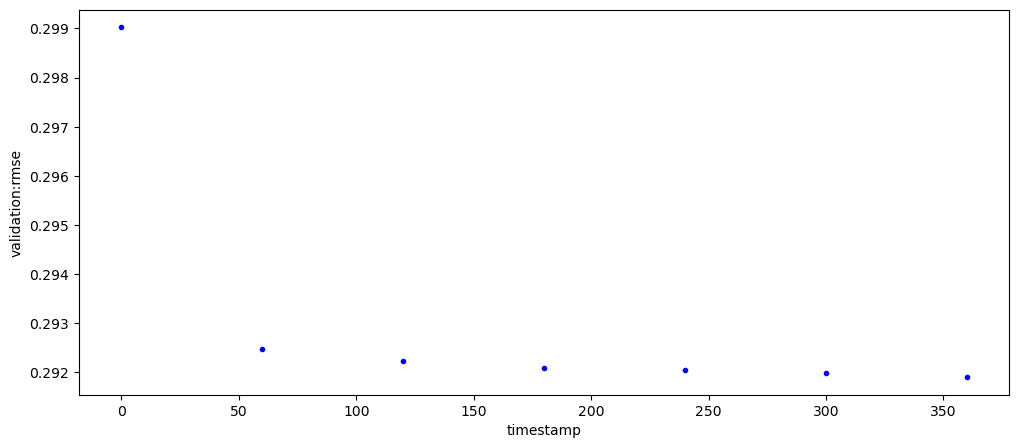

In [19]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = "validation:rmse"

metrics_dataframe = TrainingJobAnalytics(
    training_job_name=training, metric_names=[metric_name]
).dataframe()
plt = metrics_dataframe.plot(
    kind="line", figsize=(12, 5), x="timestamp", y="value", style="b.", legend=False
)
plt.set_ylabel(metric_name)